# MLP

## Imports

In [25]:
import torch
import os
import sys
sys.path.append('../../scaling_mlps/')
from models.networks import get_model
from torch import nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from data_utils.data_stats import *
# from data_utils.dataset_to_beton import get_dataset
from utils.metrics import topk_acc, real_acc, AverageMeter

import numpy as np
import matplotlib.pyplot as plt

In [26]:
os.chdir("/home/guptav/DLProject-MLP/Experiments/Vansh/MLP")

## Hyperparams

In [27]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
data_path = '/home/vgspec/Personal/DLProject-MLP/Data'

## Set up the model
### Define Transformations + Dataloaders

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint=None)
# model = model.to(device)
# model.eval()
model_MLP = nn.Sequential(
    nn.Flatten(1, -1),model
)

In [29]:
print(model_MLP)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform_c = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_c)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BottleneckMLP(
    (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
    (linear_out): Linear(in_features=1024, out_features=10, bias=True)
    (blocks): ModuleList(
      (0-11): 12 x BottleneckBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (layernorms): ModuleList(
      (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)


## Saliency

In [30]:
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
def resize_image(input_path, size=(64, 64)):
    # Open the image
    img = Image.open(input_path)
    
    # Resize the image to the specified size
    resized_img = img.resize(size)
    return resized_img

### Google Images Dataset

In [ ]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(20):
    path_img = f'/home/guptav/DLProject-MLP/Experiments/Vansh/Sample_Images/dog ({i+1}).jpg'
    img = resize_image(path_img).convert('RGB')
    img_ten = transform_c(img).unsqueeze(0)
    img_ten = torch.reshape(img_ten, (img_ten.shape[0], -1))
    output = model(img_ten)
    if (np.argmax(output.detach()).item() == 5):
        saliency(img, model)

### CIFAR10 Dataset

cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


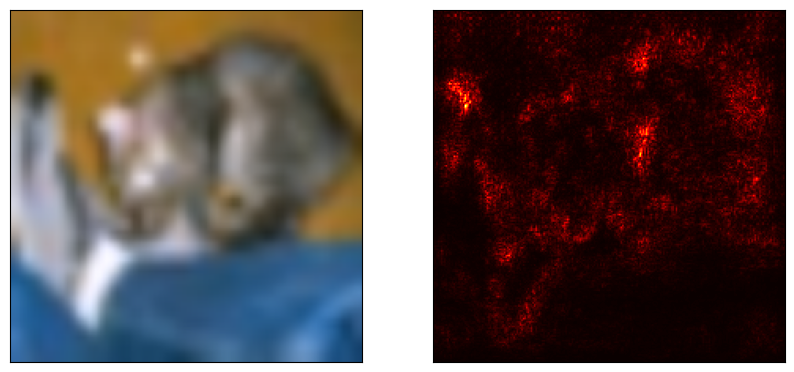

KeyboardInterrupt: 

In [23]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

transform_img = transforms.ToPILImage()

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    for input, label in zip(inputs, labels):
        output = model(input.unsqueeze(0))
        _, predicted = torch.max(output, 1)
        if (predicted == label):
            print(classes[label.item()])
            saliency(transform_img(input), model)
            # if (random.random() < 0.01):
            #     saliency(transform_img(input), model)

## Accuracy

### Google Image Dataset

In [39]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
count = 0
total = 100
for i in range(total):
    path_img = f'/home/guptav/DLProject-MLP/Experiments/Vansh/Sample_Images/dog ({i+1}).jpg'
    img = resize_image(path_img).convert('RGB')
    img_ten = transform_c(img).unsqueeze(0)
    img_ten = torch.reshape(img_ten, (img_ten.shape[0], -1))
    output = model(img_ten)
    if (np.argmax(output.detach()).item() == 5):
        count+=1
print("Model accuracy on dog images: ", count*100/total)

Model accuracy on dog images:  15.0


### CIFAR10 Dataset

In [24]:
total_ex = 0
correct_ex = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = torch.reshape(inputs, (inputs.shape[0], -1))
        inputs, labels = inputs.to(device), labels.to(device)

        for input, label in zip(inputs, labels):
            total_ex += 1
            output = model_MLP(input.unsqueeze(0))
            _, predicted = torch.max(output, 1)
            if (predicted == label):
                correct_ex += 1
    
print("Model accuracy on CIFAR10: ", correct_ex*100/total_ex)

/home/guptav/DLenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


NameError: name 'model_MLP' is not defined